# Skin Cancer Detection

## Import modules

In [1]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.preprocessing import image
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
# from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display

Using TensorFlow backend.


## Load the pretrained model

In [2]:
base_model  = InceptionV3(weights = 'imagenet', include_top=False)
print('loaded model')

loaded model


## Data Preprocessing

In [3]:
data_gen_args = dict(preprocessing_function=preprocess_input, #Define the dictionary for Image data Generator
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_datagen = image.ImageDataGenerator(**data_gen_args)
test_datagen = image.ImageDataGenerator(**data_gen_args)

### Loading Images from the Directory

In [4]:
train_generator = train_datagen.flow_from_directory("\Derma\images\train",
                                                    target_size=(299,299),batch_size=32)

valid_generator = test_datagen.flow_from_directory("Derma\images\valid",
                                                     target_size=(299,299),batch_size=32)

Found 389 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


## Benchmark Model

### Define the model architecture

In [5]:
from keras.layers import Conv2D,MaxPooling2D,Flatten

benchmark = Sequential()
benchmark.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (299,299,3)))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Dropout(0.3))
benchmark.add(Flatten())
benchmark.add(Dense(512, activation='relu'))
benchmark.add(Dropout(0.5))
benchmark.add(Dense(3, activation='softmax'))

benchmark.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 299, 299, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 150, 150, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 75, 75, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 38, 64)        0         
__________

### Compile the Model

In [6]:
benchmark.compile(loss = 'categorical_crossentropy',optimizer='rmsprop', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('saved_model/benchmark.hdf5', verbose=1,save_best_only=True)
# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=0,verbose=1,mode='auto')

### Train the model

In [47]:
history = benchmark.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=3, epochs=10,verbose=1,callbacks=[checkpointer])

Epoch 1/10
13/13 [==============================] - 28s - loss: 9.4217 - acc: 0.4155 - val_loss: 11.4618 - val_acc: 0.2889
Epoch 2/10
13/13 [==============================] - 27s - loss: 9.6553 - acc: 0.4010 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/10
13/13 [==============================] - 28s - loss: 8.6823 - acc: 0.4613 - val_loss: 10.5663 - val_acc: 0.3444
Epoch 4/10
13/13 [==============================] - 25s - loss: 9.1102 - acc: 0.4348 - val_loss: 11.1036 - val_acc: 0.3111
Epoch 5/10
13/13 [==============================] - 27s - loss: 9.4602 - acc: 0.4131 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/10
13/13 [==============================] - 27s - loss: 9.0327 - acc: 0.4396 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/10
13/13 [==============================] - 27s - loss: 8.8778 - acc: 0.4492 - val_loss: 10.5663 - val_acc: 0.3444
Epoch 8/10
13/13 [==============================] - 27s - loss: 8.9933 - acc: 0.4420 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 9/10
13/13

## Transfer Learning

In [ ]:
# Define the output layers for Inceptionv3
last = base_model.output
x = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(3,activation='softmax')(x)

model = Model(input=base_model.input,output=preds)
model.summary()

### Loading weights of benchmark model

In [8]:
#Load the weights for the common layers from the benchmark model
base_model.load_weights(filepath='saved_model/benchmark.hdf5',by_name=True)

In [9]:
#Freeze the original layers of Inception3
for layer in base_model.layers:
    layer.trainable = False

### Compile the model

In [10]:
#Compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('saved_model/transfer_learning.hdf5', verbose=1,save_best_only=True)
# Stop the traning if the model shows no improvement
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=1,verbose=1,mode='auto')

In [29]:
# Train the model
history_transfer = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=4, epochs=5,verbose=1,callbacks=[checkpointer])

Epoch 1/5
13/13 [==============================] - 620s - loss: 0.8088 - acc: 0.6642 - val_loss: 2.2174 - val_acc: 0.5410
Epoch 2/5
13/13 [==============================] - 584s - loss: 0.6725 - acc: 0.6667 - val_loss: 2.3275 - val_acc: 0.5172
Epoch 3/5
13/13 [==============================] - 577s - loss: 0.6826 - acc: 0.6812 - val_loss: 0.9925 - val_acc: 0.6148
Epoch 4/5
13/13 [==============================] - 553s - loss: 0.5841 - acc: 0.7053 - val_loss: 1.5506 - val_acc: 0.5410
Epoch 5/5
13/13 [==============================] - 545s - loss: 0.5393 - acc: 0.7102 - val_loss: 0.9172 - val_acc: 0.6466


### Display the dictionary of training metrics values

In [44]:
display(history_transfer.history)

{'acc': [0.6555269924411431,
  0.67095115711878994,
  0.68637532164321158,
  0.69922879192700427,
  0.71722365069205474],
 'loss': [0.82398341324151636,
  0.66863153296448574,
  0.69416057389315722,
  0.60379789597271039,
  0.54699874184738395],
 'val_acc': [0.54098361242012905,
  0.51724138599017566,
  0.61475410324628232,
  0.54098361144300366,
  0.64655172002726591],
 'val_loss': [2.2173500569140323,
  2.3274917766965668,
  0.99247796125099308,
  1.5506375187733135,
  0.91718116094326152]}

## Plot the graphs for accuracy and loss

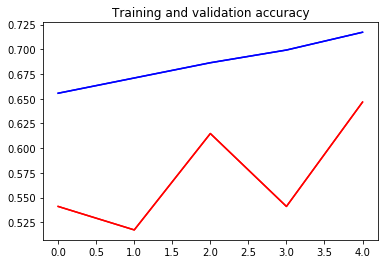

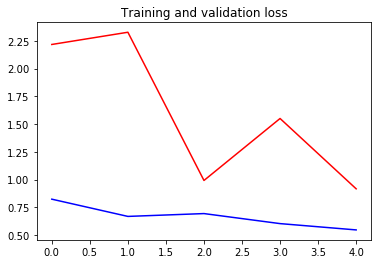

In [49]:
plot_training(history_transfer)

## Fine Tuning

In [30]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [12]:
# Unfreeze the last three inception modules
for layer in model.layers[:229]:
    layer.trainable = False
for layer in model.layers[229:]:
    layer.trainable = True

### Compile the model

In [13]:
from keras.optimizers import SGD

# Use an optimizer with slow learning rate
model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
#Save the model with best validation loss
checkpointer = ModelCheckpoint('saved_model/fine_tuning.hdf5.hdf5', verbose=1,save_best_only=True,monitor='val_loss')

# Stop the traning if the validation loss doesn't improve
stopper = EarlyStopping(monitor='val_loss,val_acc',min_delta=0.1,patience=2,verbose=1,mode='auto')

In [62]:
# Train the model
history = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=3, epochs=5,verbose=1,callbacks=[checkpointer])

Epoch 1/5
13/13 [==============================] - 649s - loss: 0.5508 - acc: 0.6908 - val_loss: 1.1368 - val_acc: 0.6889
Epoch 2/5
13/13 [==============================] - 609s - loss: 0.5065 - acc: 0.7029 - val_loss: 1.0971 - val_acc: 0.6778
Epoch 3/5
13/13 [==============================] - 601s - loss: 0.5006 - acc: 0.7150 - val_loss: 0.8329 - val_acc: 0.6556
Epoch 4/5
13/13 [==============================] - 602s - loss: 0.5560 - acc: 0.7367 - val_loss: 0.4621 - val_acc: 0.7667
Epoch 5/5
13/13 [==============================] - 625s - loss: 0.8897 - acc: 0.6474 - val_loss: 0.5531 - val_acc: 0.6778


## Predict Function

In [15]:
# Load the weights fromt the fine-tuned model
model.load_weights('saved_model/fine_tuning.hdf5.hdf5')

In [17]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (299,299)) #Load the image and set the target size to the size of input of our model
    x = img_to_array(img) #Convert the image to array
    x = np.expand_dims(x,axis=0) #Convert the array to the form (1,x,y,z) 
    x = preprocess_input(x) # Use the preprocess input function o subtract the mean of all the images
    p = np.argmax(model.predict(x)) # Store the argmax of the predictions
    if p==0:     # P=0 for basal,P=1 for melanoma , P=2 for squamous
        print("basal")
    elif p==1:
        print("melanoma")
    elif p==2:
        print("squamous")

basal


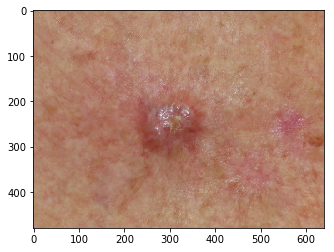

In [19]:
pred("\Derma\test\bas-1.jpg")
z = plt.imread('\Derma\test\bas-1.jpg') 
plt.imshow(z);         #print the loaded image

basal


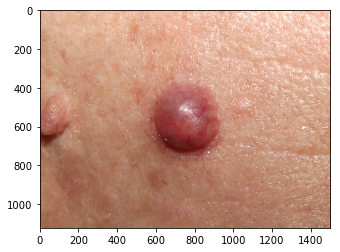

In [20]:
pred("\Derma\test\bas-2.jpg")
z = plt.imread('\Derma\test\bas-2.jpg')
plt.imshow(z);

squamous


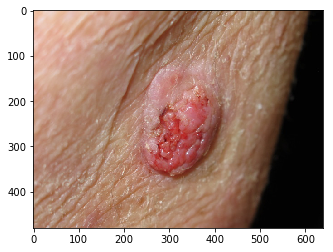

In [21]:
pred("\Derma\test\sqa-1.jpg")
z = plt.imread('\Derma\test\sqa-1.jpg')
plt.imshow(z);

basal


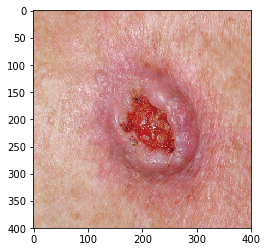

In [24]:
pred("\Derma\test\sqa-2.jpg")
z = plt.imread('\Derma\test\sqa-2.jpg')
plt.imshow(z);

melanoma


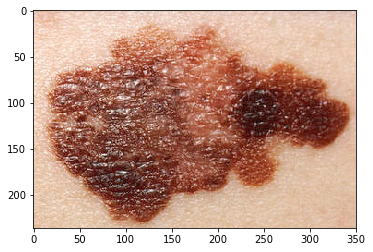

In [22]:
pred("\Derma\test\mel-1.jpg")
z = plt.imread('\Derma\test\mel-1.jpg')
plt.imshow(z);

melanoma


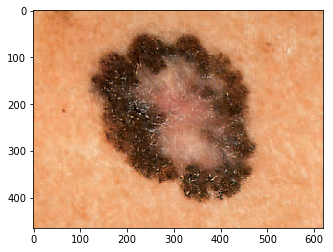

In [23]:
pred("\Derma\test\mel-2.jpg")
z = plt.imread('\Derma\test\mel-2.jpg')
plt.imshow(z);

### Display the dictionary of training metrics values

In [63]:
display(history.history)

{'acc': [0.68380462740258263,
  0.70951156842984398,
  0.72236503886686187,
  0.73264781506325105,
  0.68894601542416456],
 'loss': [0.55257826491922213,
  0.50854348209339428,
  0.50623004218912981,
  0.57061414194597382,
  0.60188546094918927],
 'val_acc': [0.68888889286253185,
  0.67777777512868242,
  0.65555556085374622,
  0.76666666004392836,
  0.67777778572506375],
 'val_loss': [1.1368412693341574,
  1.0971041891309949,
  0.83293846580717301,
  0.4621268782350752,
  0.55309360027313237]}

### Method for plotting graphs

In [64]:
def plot_training(history):
    acc = history.history['acc'] 
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs  = range(len(acc))
    
    plt.plot(epochs,acc,'b')
    plt.plot(epochs,val_acc,'r')
    plt.title("Training and validation accuracy")
    
    plt.figure()
    plt.plot(epochs,loss,'b')
    plt.plot(epochs,val_loss,'r')
    plt.title("Training and validation loss")
    
    plt.show()

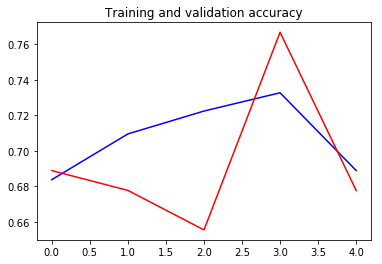

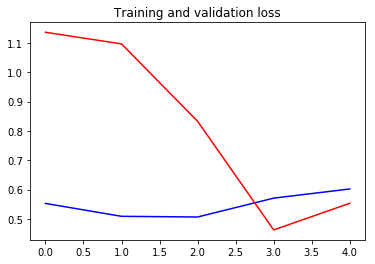

In [65]:
plot_training(history)